In [1]:
import hyperspy.api as hs
import numpy as np
import scipy.ndimage as ndi
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches
import matplotlib
path = os.getcwd() + "/"
plt.set_cmap("cubehelix")
plt.close()

%matplotlib inline
matplotlib.rcParams.update(
    {'figure.figsize': (7,7)})

#dp = hs.load(path + "05 nbd 30 cm.dm3")
#dp = hs.load(path + "nbd 40cm aperture 3.dm3")
#dat=dp.data
#dat=dat.astype("double")

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)         
                        + c*((y-yo)**2)))                                   
    return g.ravel()

In [2]:
imagelist=[]
for root,dirs,files in os.walk(path):
    for name in files:
        if name[-4:] == ".dm3":
            print(os.path.join(root,name))
            imagelist.append(os.path.join(root,name))
        if name[-5:] == ".tiff":
            print(os.path.join(root,name))
            imagelist.append(os.path.join(root,name))
        if name[-5:] == ".hdf5":
            print(os.path.join(root,name))
            imagelist.append(os.path.join(root,name))

/Users/mofo/Google Drive/Python/ImageAnalysis/Diffraction/test_files/04 nbd cl4 spot 1nm.dm3
/Users/mofo/Google Drive/Python/ImageAnalysis/Diffraction/test_files/05 nbd 30 cm.dm3
/Users/mofo/Google Drive/Python/ImageAnalysis/Diffraction/test_files/nbd 3.dm3
/Users/mofo/Google Drive/Python/ImageAnalysis/Diffraction/test_files/nbd 40cm aperture 3.dm3
/Users/mofo/Google Drive/Python/ImageAnalysis/Diffraction/test_files/nbd central spot ap 4 200cm with OA 4.hdf5


In [3]:
dp = hs.load(imagelist[0])
dp.data=dp.data.astype("double")

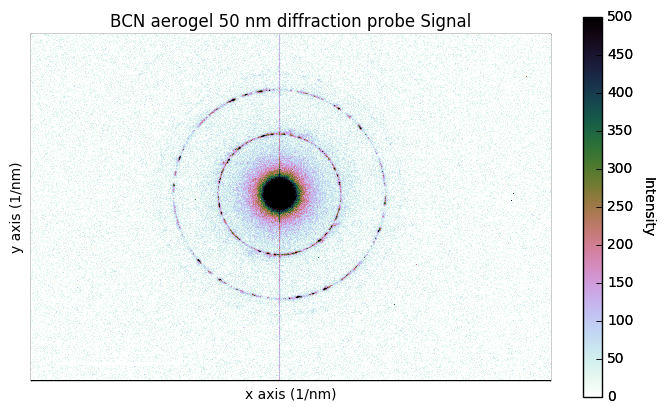

In [212]:
dp.metadata.General.title = "BCN aerogel 50 nm diffraction probe"
dp.plot(vmin=0,vmax=500)

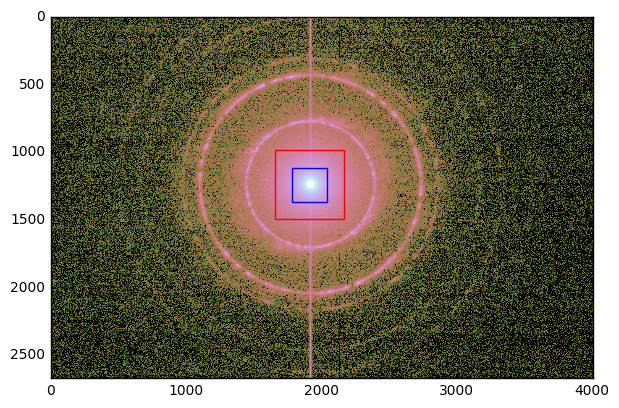

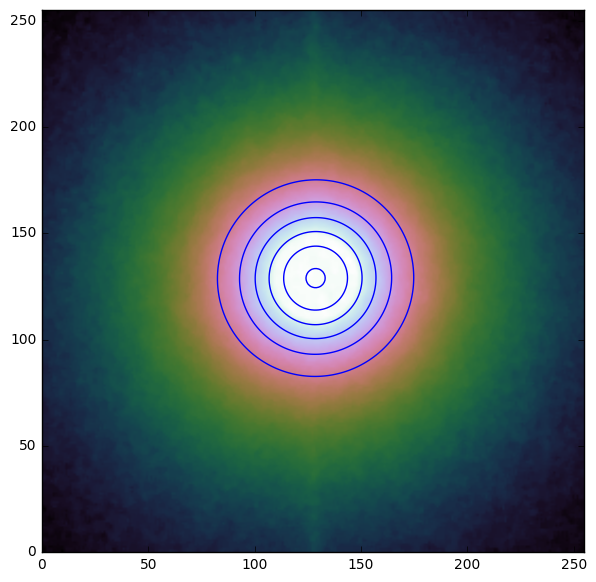

Amplitude (Counts): 29801.5545559
Center X (pix): 128.629665508
Center Y (pix): 128.947181386
Sigma X (pix): 23.4652775731
Sigma Y (pix): 23.3086376124
Theta (Deg): -52.5279731907
Offset (Counts): 752.051343117


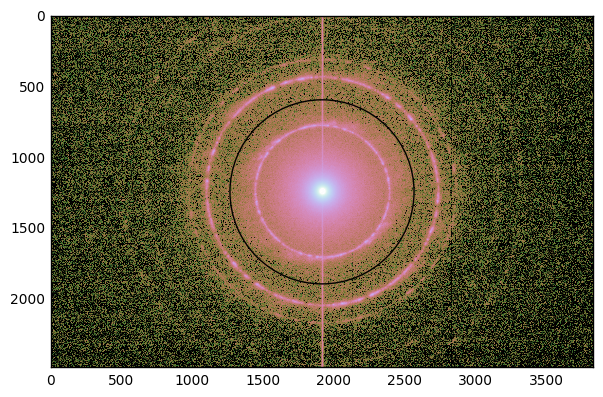

In [4]:
#user parameters

MedianKernelSize =3
MinimumPixelValue = 0.01

SearchBox1_Sizex = 512
SearchBox1_Sizey = 512

SearchBox2_Sizex = 256
SearchBox2_Sizey = 256

GaussianKernelSigma =10.0
FitContours = 6
FitColor = 'b'


#Start of Routine
med=ndi.filters.median_filter(dp.data,MedianKernelSize) #median filtered image
med=med-med.min()+ MinimumPixelValue #removing any negative pixels 


#image dimensions
sx=len(dp.data[0]) 
sy=len(dp.data)

cent1=np.array(ndi.measurements.center_of_mass(med)) #finding centroid of first cropped image

#defines search box for central spot
h=SearchBox1_Sizex
w=SearchBox1_Sizey

#crops out search box
xmin=int((cent1-[h/2,w/2])[1])
xmax=int((cent1+[h/2,w/2])[1])
ymin=int((cent1-[h/2,w/2])[0])
ymax=int((cent1+[h/2,w/2])[0])
area=med[ymin:ymax,xmin:xmax]


#finds centroid of cropped area
cent2=np.array(ndi.measurements.center_of_mass(area)) #finding centroid of first cropped image

#defines region for fit
w2=SearchBox2_Sizex
h2=SearchBox2_Sizey

#crops out image to preform fit on
xmin2=int((cent2-[w2/2,h2/2])[1])
xmax2=int((cent2+[w2/2,h2/2])[1])
ymin2=int((cent2-[w2/2,h2/2])[0])
ymax2=int((cent2+[w2/2,h2/2])[0])
fit_area=area[ymin2:ymax2,xmin2:xmax2]

#plt.imshow(np.log(fit_area))
#plt.show()
plt.close()
fig,ax = plt.subplots(1)
ax.imshow(np.log(med))
rect = patches.Rectangle([xmin,ymin],w,h,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
rect2 = patches.Rectangle(np.array([xmin,ymin])+cent2-[h2/2,w2/2],w2,h2,linewidth=1,edgecolor='b',facecolor='none')
ax.add_patch(rect2)
plt.show()

#performs gaussian smoothing to "desaturate" peak
gaus = ndi.filters.gaussian_filter(fit_area,GaussianKernelSigma)

# Create x and y indices
x = np.arange(0, len(gaus[0]), 1)
y = np.arange(0, len(gaus), 1)
x,y = np.meshgrid(x, y)

#amplitude center_x, center_y, sigma_x, sigma_y, theta, offset 
#parameters are estimated as:
#Amplitude = Max Value
#center_x, center_y = middle pixel
#sigma_x, sigma_y = sigma for gaussian blur
#theta = 0
#offset = Min Value
p0 = [gaus.max(),len(x)/2,len(y)/2,GaussianKernelSigma,GaussianKernelSigma,0,gaus.min()]

#Non-Linear LSq fitting
coeff, var_matrix = curve_fit(twoD_Gaussian, (x, y), gaus.ravel(), p0=p0)
data_fitted = twoD_Gaussian((x, y), *coeff)

#plots fit results
fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.imshow(np.log(fit_area), origin='bottom',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(len(x),len(y)), FitContours, colors=FitColor)
plt.show()

print("Amplitude (Counts): "+ str(coeff[0]))
print("Center X (pix): "+ str(coeff[1]))
print("Center Y (pix): "+ str(coeff[2]))
print("Sigma X (pix): "+ str(coeff[3]))
print("Sigma Y (pix): "+ str(coeff[4]))
print("Theta (Deg): "+ str(180/np.pi*coeff[5]))
print("Offset (Counts): "+ str(coeff[6]))

centroid_total = np.array([xmin+xmin2,ymin+ymin2])+np.array([coeff[1],coeff[2]])

cx=centroid_total[0]
cy=centroid_total[1]
csx=min([cx,len(med[0])-cx])
csy=min([cy,len(med)-cy])
square_size=min([csx,csy])
center_crop_square = med[int(cy-square_size):int(cy+square_size),int(cx-square_size):int(cx+square_size)]
center_crop = med[int(cy-csy):int(cy+csy),int(cx-csx):int(cx+csx)]

radius =650
fig,ax = plt.subplots(1)
ax.imshow(np.log(center_crop))
circ = patches.Circle(np.array([len(center_crop[0])/2,len(center_crop)/2]),radius,linewidth=1,edgecolor='k',facecolor='none')
ax.add_patch(circ)
plt.show()


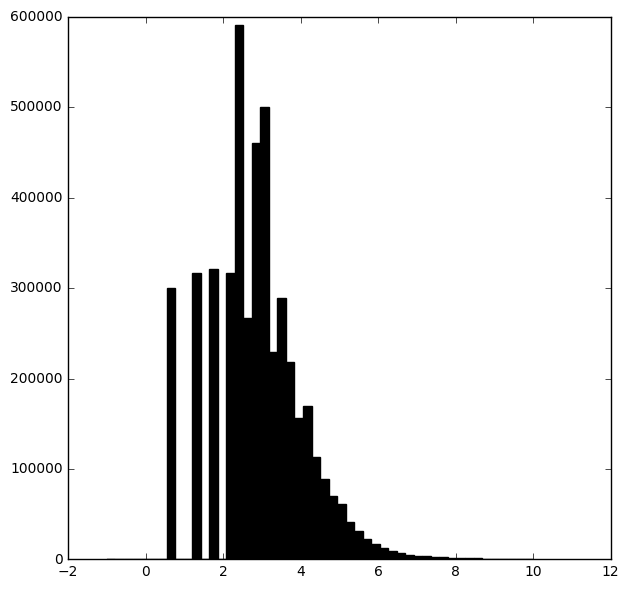

In [20]:
meow=plt.hist(np.log(center_crop).ravel(),bins=50, range = (-1,10), fc='k', ec='k')

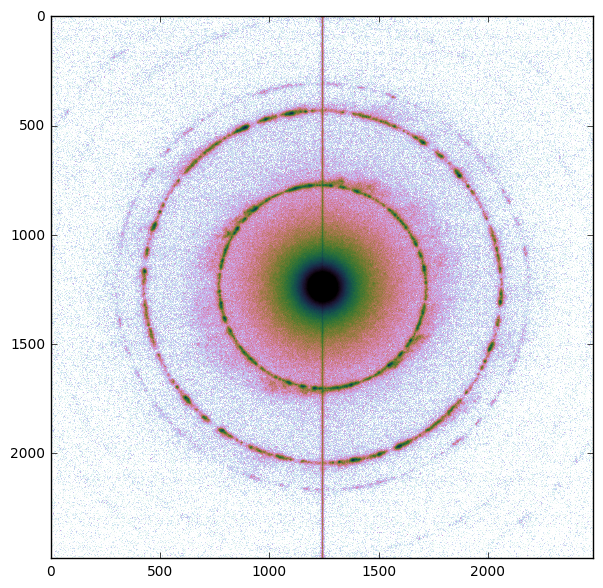

In [5]:
cx=centroid_total[0]
cy=centroid_total[1]
csx=min([cx,len(med[0])-cx])
csy=min([cy,len(med)-cy])
square_size=min([csx,csy])
center_crop = med[int(cy-square_size):int(cy+square_size),int(cx-square_size):int(cx+square_size)]
plt.imshow(np.log(center_crop),vmin=2,vmax=7.5)
plt.set_cmap("cubehelix_r")
plt.show()

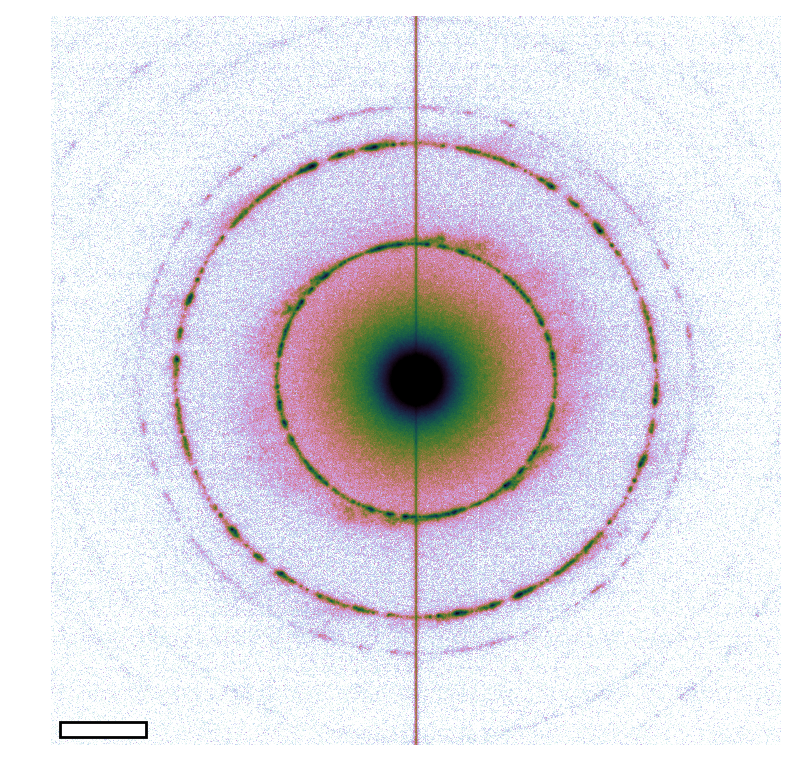

In [6]:
im=np.log(center_crop)
pixel_cal = dp.axes_manager[0].scale

fig, (ax) = plt.subplots(1,1,figsize=(8,8))
fig.set_canvas(plt.gcf().canvas)

plt.set_cmap('cubehelix_r')

ax.axis('off')
img = ax.imshow(im,vmin=2,vmax=7)
ax.axis('off')

bar_size = 3
bar_len = bar_size/pixel_cal

margin = 30
thick = 50
bar_loc = (margin,len(center_crop)-margin-thick)
rect1 = patches.Rectangle(bar_loc,bar_len,thick,linewidth=2,edgecolor='k',facecolor='w')
ax.add_patch(rect1)

plt.tight_layout()
plt.show()

#fig.savefig(path + "centered.pdf",dpi = 300, format='pdf')

In [7]:
#assumes image is properly centered

from scipy.ndimage.interpolation import geometric_transform

def topolar(img, order=1):
    """
    Transform img to its polar coordinate representation.

    order: int, default 1
        Specify the spline interpolation order. 
        High orders may be slow for large images.
    """
    # max_radius is the length of the diagonal 
    # from a corner to the mid-point of img.
    max_radius = 0.5*np.linalg.norm( img.shape )

    def transform(coords):
        # Put coord[1] in the interval, [-pi, pi]
        theta = 2*np.pi*coords[1] / (img.shape[1] - 1.)

        # Then map it to the interval [0, max_radius].
        #radius = float(img.shape[0]-coords[0]) / img.shape[0] * max_radius
        radius = max_radius * coords[0] / img.shape[0]

        i = 0.5*img.shape[0] - radius*np.sin(theta)
        j = radius*np.cos(theta) + 0.5*img.shape[1]
        return i,j

    polar = geometric_transform(img, transform, order=order)

    rads = max_radius * np.linspace(0,1,img.shape[0])
    angs = np.linspace(0, 2*np.pi, img.shape[1])

    return polar, (rads, angs)

In [8]:
img = np.log(center_crop)
pol, (rads,angs) = topolar(img)

In [52]:
rads

array([  0.00000000e+00,   7.07534481e-01,   1.41506896e+00, ...,
         1.75327044e+03,   1.75397798e+03,   1.75468551e+03])

In [175]:
pixel_cal = dp.axes_manager[0].scale
x0 = -len(img)*pixel_cal/2

step = 2
tickee_calib = np.arange(np.ceil(x0),np.floor(abs(x0))+step,step).astype('int')
tickee = (tickee_calib - x0)/pixel_cal


rad_step = 1
rads_cal = np.sqrt(2)*np.abs(x0)/len(rads)
rad_tickee_calib = np.arange(0,np.floor(abs(x0)*np.sqrt(2))+rad_step,rad_step).astype('int')
rad_tickee = rad_tickee_calib/rads_cal

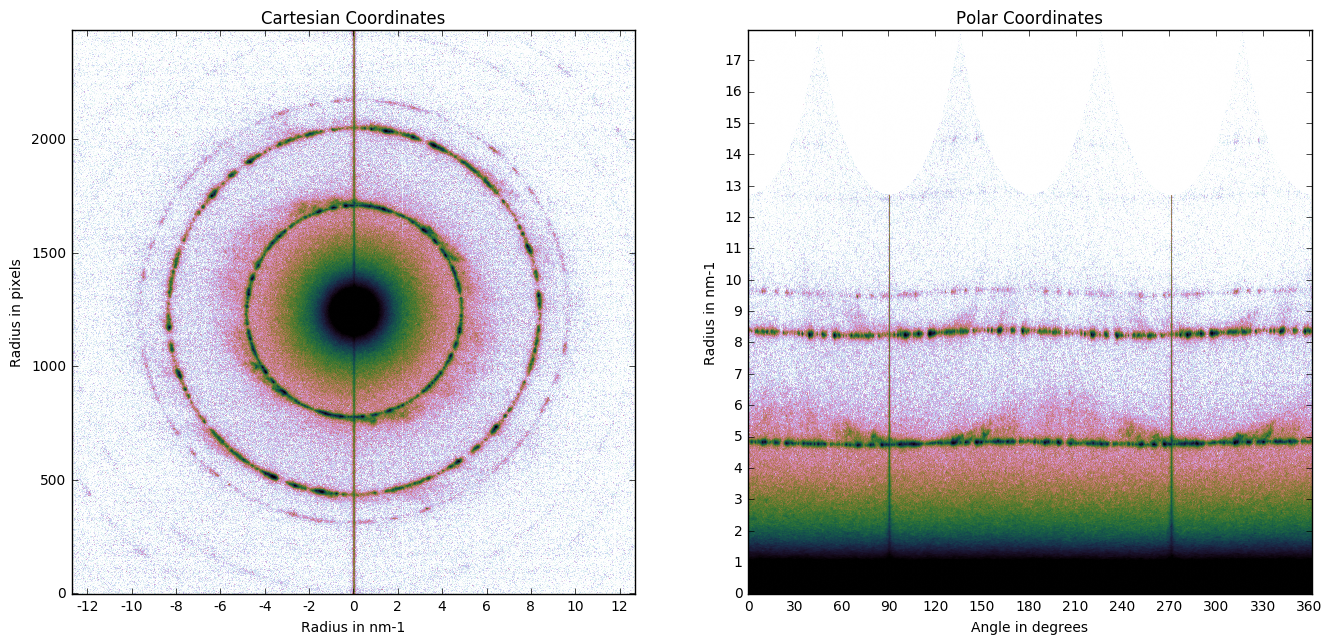

In [176]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

ax[0].imshow(img, cmap=plt.cm.cubehelix_r, interpolation='bicubic',vmin=2,vmax=6.5,origin="lower")
ax[0].set_title("Cartesian Coordinates")

ax[0].set_xticks(tickee)
ax[0].set_xticklabels(tickee_calib)
ax[0].set_xlabel("Radius in nm-1")
ax[0].set_ylabel("Radius in pixels")

ax[1].imshow(pol, cmap=plt.cm.cubehelix_r, interpolation='bicubic',vmin=2,vmax=6.5,origin="lower")
ax[1].set_title("Polar Coordinates")

ax[1].set_ylabel("Radius in nm-1")
ax[1].set_yticks(rad_tickee)
ax[1].set_yticklabels(rad_tickee_calib)

ax[1].set_xlabel("Angle in degrees")
ax[1].set_xticks(range(0, img.shape[1]+1, int(len(angs)/12)))
ax[1].set_xticklabels(np.arange(0,360+30,30))

plt.show()

/Users/mofo/anaconda/envs/hyperspy_new/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


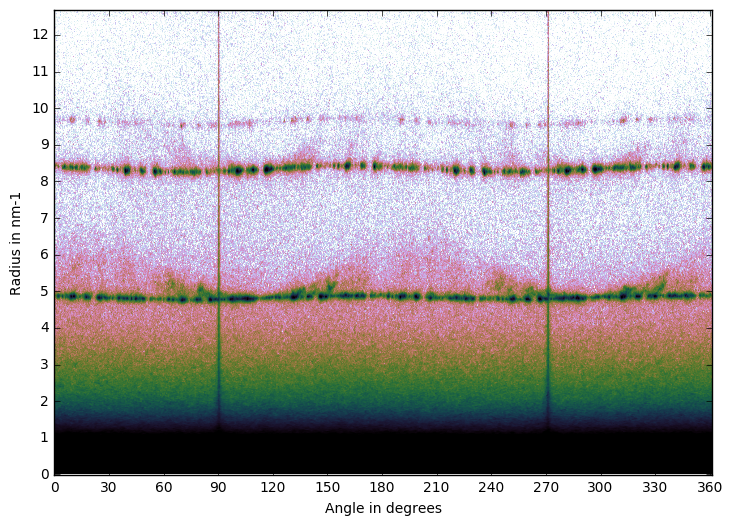

In [191]:
rad_tickee_calib_crop = np.arange(0,np.floor(abs(x0))+rad_step,rad_step).astype('int')
rad_tickee_crop = rad_tickee_calib_crop/rads_cal

fig,ax = plt.subplots(1,1,figsize=(9,6))

pol_cropped = pol[:len(pol)/np.sqrt(2),:]
plt.imshow(pol_cropped,origin="lower",vmin=2.0,vmax=6.5,cmap=plt.cm.cubehelix_r)

ax.set_ylabel("Radius in nm-1")
ax.set_yticks(rad_tickee_crop)
ax.set_yticklabels(rad_tickee_calib_crop)

ax.set_xlabel("Angle in degrees")
ax.set_xticks(range(0, img.shape[1]+1, int(len(angs)/12)))
ax.set_xticklabels(np.arange(0,360+30,30))

plt.show()

In [12]:
print("New Size: ",len(pol[:len(pol)/np.sqrt(2),:].ravel()))
print("Original Size: ",len(center_crop.ravel()))

New Size:  4353428
Original Size:  6157842


/Users/mofo/anaconda/envs/hyperspy_new/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


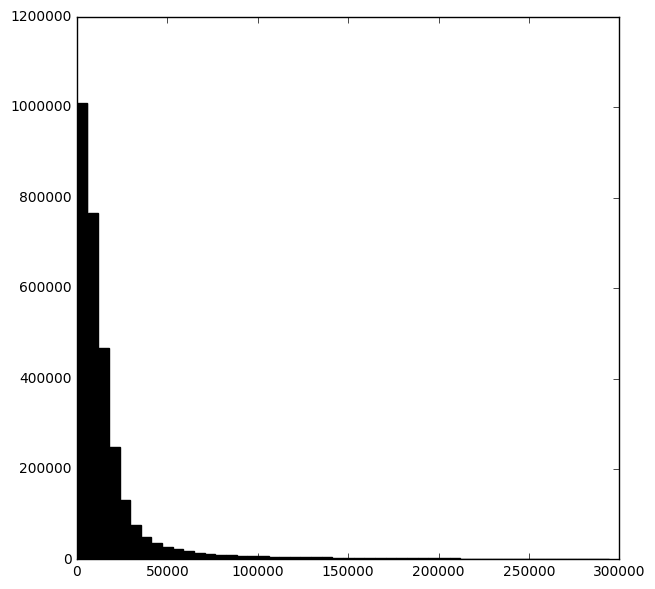

In [40]:
from scipy.fftpack import fft2

meow = fft2(center_crop)
beep = np.abs(meow)
beepp = np.angle(meow)
beepr = meow.real
beepi = meow.imag

#beep
#plt.imshow(meow.real,cmap=plt.cm.cubehelix_r,origin='lower')
#plt.show()

#print(meow.shape)
#print(pol_cropped.shape)

nono=plt.hist(beepr.ravel(),bins=50,range=(beep.ravel().min(),0.001*beep.ravel().max()), fc='k', ec='k')
plt.show()

/Users/mofo/anaconda/envs/hyperspy_new/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/Users/mofo/anaconda/envs/hyperspy_new/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log


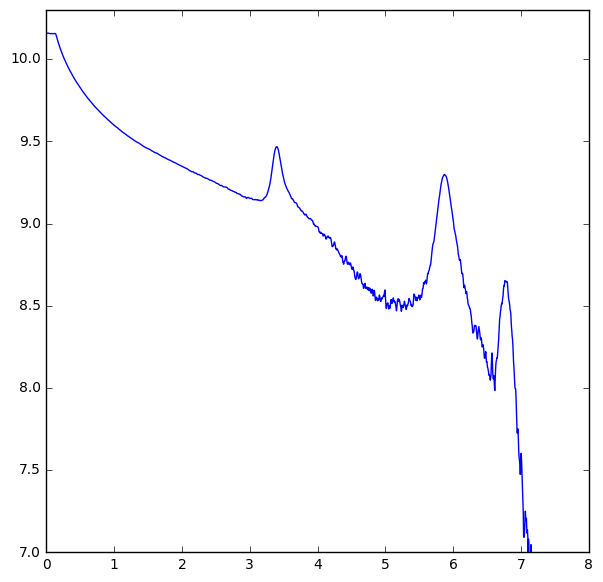

In [207]:
new=pol[:len(pol)/np.sqrt(2),:]
rad = new.sum(1)
thet = new.sum(0)

xx = rads*rads_cal
xx = xx[:len(rad)]
yy = rad

plt.plot(xx,np.log(yy))
#plt.plot(thet)
#plt.ylim(8600,8800)
plt.ylim(7.0,10.3)
plt.show()

In [205]:
rads_cal

0.0072403906420737867

In [ ]:
#powerlaw fit to background
bot=3.5
top=4.5

xx=np.array(radial_int).transpose()[0]
yy=np.array(radial_int).transpose()[1]

xl=np.log(xx)
yl=np.log(yy)
fit_range=np.where(np.logical_and(xl<=top,xl>=bot))

xlc=xl[fit_range[0]]
ylc=yl[fit_range[0]]

z=np.polyfit(xlc,ylc,1)
p=np.poly1d(z)


plt.plot(xl,yl)
plt.plot(xl,p(xl),'r')
plt.plot()
plt.plot
plt.xlim(3,np.log(square_size))
plt.ylim(3,7)
plt.show()

A= np.exp(z[1])
r= z[0]

In [177]:
#rotational averaging
lx=len(center_crop)
ly=len(center_crop)
imarg = np.array([(x, y) for x in range(0,lx) for y in range(0,ly)])
imarg = np.split(imarg,lx)
imcen = np.zeros((lx,ly,2))+0.5*np.array((lx,ly))
imcen2 = imarg - imcen
theta=(180/np.pi)*np.arctan2(imcen2[:,:,0],imcen2[:,:,1])
rho=np.sqrt(imcen2[:,:,1]**2+imcen2[:,:,0]**2)

rhodata = np.array([(rho[x,y],center_crop[x,y]) for x in range(0,lx-1) for y in range(0,ly-1)])
rhodata = np.transpose(rhodata)
#x=rhodata[0]
#y=rhodata[1]
#plt.plot(x,y,'ro')
#plt.show()

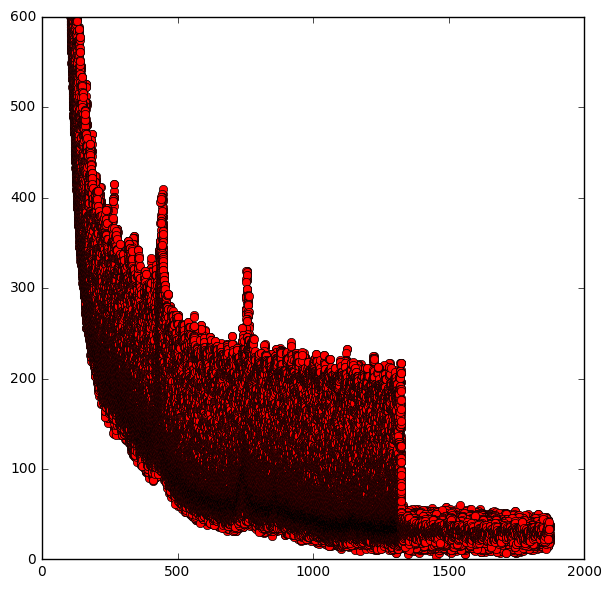

In [15]:
x=rhodata[0]
y=rhodata[1]
plt.plot(x,y,'ro')
plt.ylim(0,600)
plt.show()

In [178]:
radial_bin=2

rhodatat=rhodata.transpose()
radial_sort=rhodatat[np.lexsort((rhodatat[:,1],rhodatat[:,0]))]
j=1.0
radial_int=[]
meow=[]
for x in radial_sort:
    if x[0]<=square_size:
        if x[0]<=j:
            meow.append([x[0],x[1]])
        else:
            radial_int.append(np.array(meow).mean(0))
            meow=[]
            j+=radial_bin  

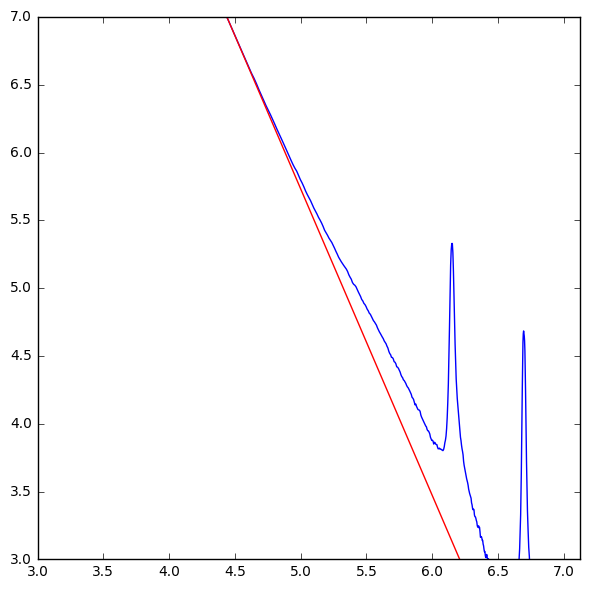

In [179]:
#powerlaw fit to background
bot=3.5
top=4.5

xx=np.array(radial_int).transpose()[0]
yy=np.array(radial_int).transpose()[1]

xl=np.log(xx)
yl=np.log(yy)
fit_range=np.where(np.logical_and(xl<=top,xl>=bot))

xlc=xl[fit_range[0]]
ylc=yl[fit_range[0]]

z=np.polyfit(xlc,ylc,1)
p=np.poly1d(z)


plt.plot(xl,yl)
plt.plot(xl,p(xl),'r')
plt.plot()
plt.plot
plt.xlim(3,np.log(square_size))
plt.ylim(3,7)
plt.show()

A= np.exp(z[1])
r= z[0]

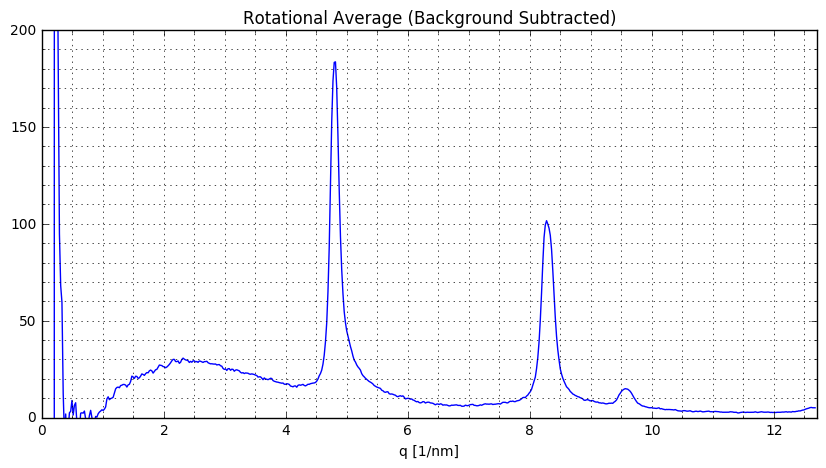

In [183]:
xcal=xx*dp.axes_manager[0].scale
plt.figure(figsize=(10,5))
plt.plot(xcal,yy-A*(xx)**(r))
plt.xlim(0,square_size*dp.axes_manager[0].scale)
plt.ylim(0,200)

plt.xlabel("q [" + dp.axes_manager[0].units + "]" )
plt.title("Rotational Average (Background Subtracted)")

plt.grid(True,which="both")
plt.minorticks_on()
plt.show()

In [ ]:
def OneDGaus(x,A,x0,s,off):
    return off+A*np.exp(-(x-x0)**2/(2*s**2))

def TwoOneDGaus(xx,AA,BB,xx0,yy0,ss1,ss2,off):
    return off + (AA*np.exp(-(xx-xx0)**2/(2*ss1**2))) + (BB*np.exp(-(xx-yy0)**2/(2*ss2**2)))

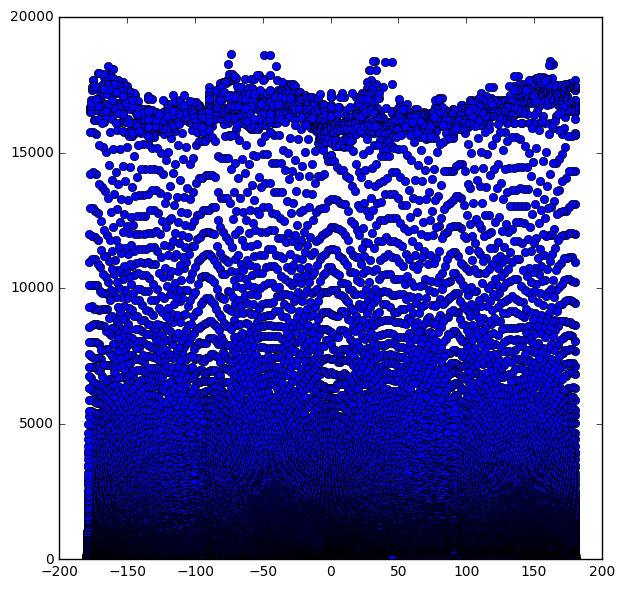

In [22]:
thetadata = np.array([(theta[x,y],center_crop[x,y]) for x in range(0,lx-1) for y in range(0,ly-1)])
thetadata = np.transpose(thetadata)
xx=thetadata[0]
yy=thetadata[1]
plt.plot(xx,yy,'bo')
plt.show()

In [69]:
theta_bin=2

thetadatat=thetadata.transpose()
theta_sort=thetadatat[np.lexsort((thetadatat[:,1],thetadatat[:,0]))]
r_theta=thetadatat[np.lexsort((rhodatat[:,1],rhodatat[:,0]))]

j=-179.0
theta_int=[]
meow=[]

for x in theta_sort:
    #if x[0]<=square_size:
        if x[0]<=j:
            meow.append([x[0],x[1]])
        else:
            theta_int.append(np.array(meow).mean(0))
            meow=[]
            j+=theta_bin  
xx=np.array(theta_int).transpose()[0]
yy=np.array(theta_int).transpose()[1]

In [70]:
theta_bin=2

r_theta_sort=[[radial_sort[x,0],r_theta[x,0],radial_sort[x,1]] for x in range(0,len(radial_sort))]
r_bot = 6.0
r_top = 7.0

j=-179.0
r_theta_int=[]
meow=[]

for x in r_theta_sort:
    #if x[0]<=square_size:
    if x[0]>=r_bot and x[0]<=r_top:
        if x[1]<=j:
            meow.append([x[1],x[2]])
        else:
        #    r_theta_int.append(np.array(meow).mean(0))
        #    meow=[]
        #    j+=theta_bin  
#xx=np.array(r_theta_int).transpose()[0]
#yy=np.array(r_theta_int).transpose()[1]

True
True
True
True
True
True
True
True
True
True
True
True


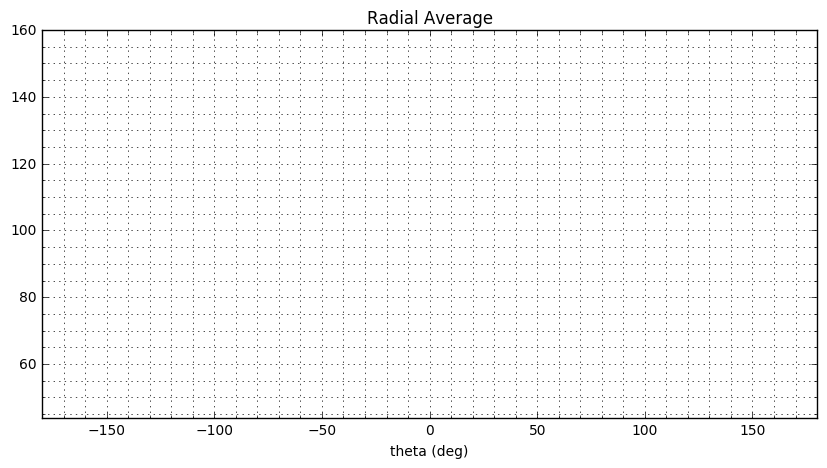

In [61]:
plt.figure(figsize=(10,5))
plt.plot(xx,yy)
plt.xlim(-180,180)
plt.ylim(44,160)

plt.xlabel("theta (deg)" )
plt.title("Radial Average")

plt.grid(True,which="both")
plt.minorticks_on()
#plt.grid(True,which="minor")
plt.show()